# Network Analysis: NYC Taxi Flow Patterns

## Overview
This notebook analyzes the NYC taxi network as a graph structure to identify:
- **Hub zones**: Most influential locations using PageRank
- **Communities**: Clusters of zones with strong internal connections
- **Flow patterns**: Trip volume between key locations

## Objectives
1. Build directed graph from pickup-dropoff pairs
2. Calculate PageRank to identify true hotspots
3. Detect communities using modularity optimization
4. Visualize hub connectivity patterns

## Business Value
- Optimize driver positioning strategies
- Identify underserved connections
- Understand zone interdependencies

## 1. Setup & Imports

In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import polars as pl
import seaborn as sns

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## 2. Load Network Data

In [2]:
uri = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST')}:5432/{os.getenv('POSTGRES_DB')}"

query = """
SELECT 
    pickup_location_id as source,
    dropoff_location_id as target,
    COUNT(*) as weight
FROM dbt_dev.fct_trips
GROUP BY 1, 2
HAVING COUNT(*) > 50
"""
edges_df = pl.read_database_uri(query, uri, engine="connectorx")

print(f"✅ Loaded {len(edges_df):,} edges (zone pairs)")
print(f"📊 Total trips: {edges_df['weight'].sum():,}")
print(f"📍 Unique zones: {edges_df.select([pl.col('source'), pl.col('target')]).to_series().unique().len()}")

✅ Loaded 11,158 edges (zone pairs)
📊 Total trips: 17,857,204
📍 Unique zones: 216


## 3. Build Network Graph

In [3]:
G = nx.DiGraph()

for row in edges_df.iter_rows(named=True):
    G.add_edge(row['source'], row['target'], weight=row['weight'])

print(f"🕸️ Graph: {G.number_of_nodes()} nodes, {G.number_of_edges():,} edges")
print(f"📈 Density: {nx.density(G):.4f}")
print(f"🔗 Avg degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.1f}")

🕸️ Graph: 247 nodes, 11,158 edges
📈 Density: 0.1836
🔗 Avg degree: 90.3


## 4. PageRank Analysis: Identifying Hub Zones

PageRank measures zone importance based on incoming connections weighted by trip volume. High PageRank indicates zones where passengers are statistically likely to end up.

In [4]:
pagerank = nx.pagerank(G, weight='weight')
top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:15]

pr_df = pl.DataFrame({
    'zone_id': [n[0] for n in top_nodes],
    'pagerank': [n[1] for n in top_nodes]
})

print("\n🎯 Top 15 Zones by PageRank (Network Importance)\n")
for node, rank in top_nodes:
    print(f"Zone {node:>3}: {rank:.5f}")


🎯 Top 15 Zones by PageRank (Network Importance)

Zone 236: 0.02265
Zone 237: 0.02125
Zone 161: 0.01864
Zone   1: 0.01738
Zone 230: 0.01554
Zone 170: 0.01537
Zone 239: 0.01500
Zone 142: 0.01452
Zone  68: 0.01432
Zone 162: 0.01427
Zone 141: 0.01372
Zone 140: 0.01364
Zone  79: 0.01336
Zone  48: 0.01316
Zone 238: 0.01304


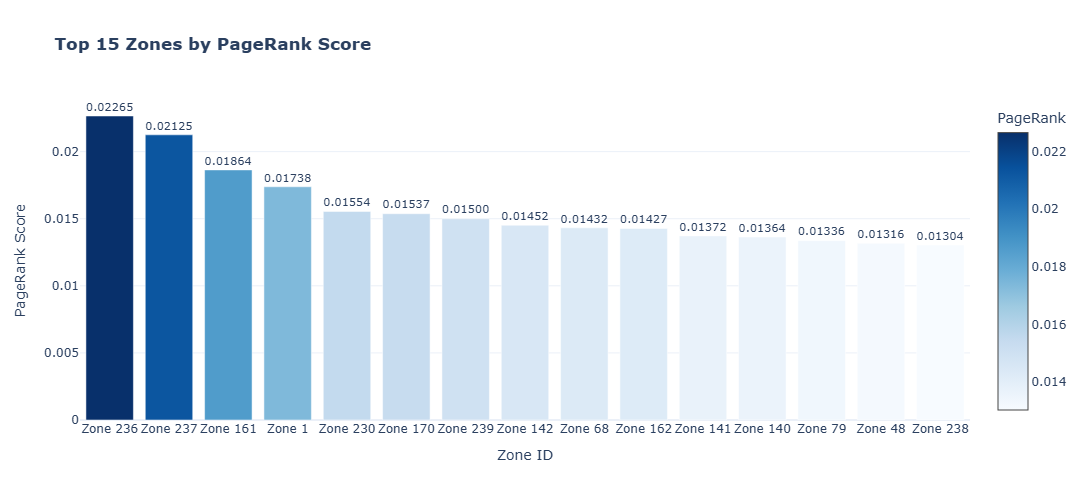

In [5]:
fig = go.Figure(data=[
    go.Bar(
        x=[f"Zone {z}" for z in pr_df['zone_id']],
        y=pr_df['pagerank'],
        marker=dict(
            color=pr_df['pagerank'],
            colorscale='Blues',
            showscale=True,
            colorbar=dict(title="PageRank")
        ),
        text=[f"{v:.5f}" for v in pr_df['pagerank']],
        textposition='outside'
    )
])

fig.update_layout(
    title="<b>Top 15 Zones by PageRank Score</b>",
    xaxis_title="Zone ID",
    yaxis_title="PageRank Score",
    template="plotly_white",
    height=500,
    showlegend=False
)
fig.show()

## 5. Community Detection: Zone Clusters

Communities represent groups of zones with high internal connectivity. This reveals geographic or functional clustering patterns.

In [6]:
communities = nx.community.greedy_modularity_communities(G, weight='weight')

print(f"\n🏘️ Detected {len(communities)} distinct communities\n")
for i, comm in enumerate(sorted(communities, key=len, reverse=True)[:5]):
    zones = sorted(list(comm))[:15]
    print(f"Community {i+1} ({len(comm)} zones): {zones}{'...' if len(comm) > 15 else ''}")


🏘️ Detected 4 distinct communities

Community 1 (182 zones): [3, 6, 7, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22]...
Community 2 (35 zones): [1, 4, 12, 13, 45, 48, 50, 68, 79, 87, 88, 90, 100, 107, 113]...
Community 3 (29 zones): [24, 41, 42, 43, 74, 75, 116, 127, 128, 140, 141, 142, 143, 151, 152]...
Community 4 (1 zones): [264]


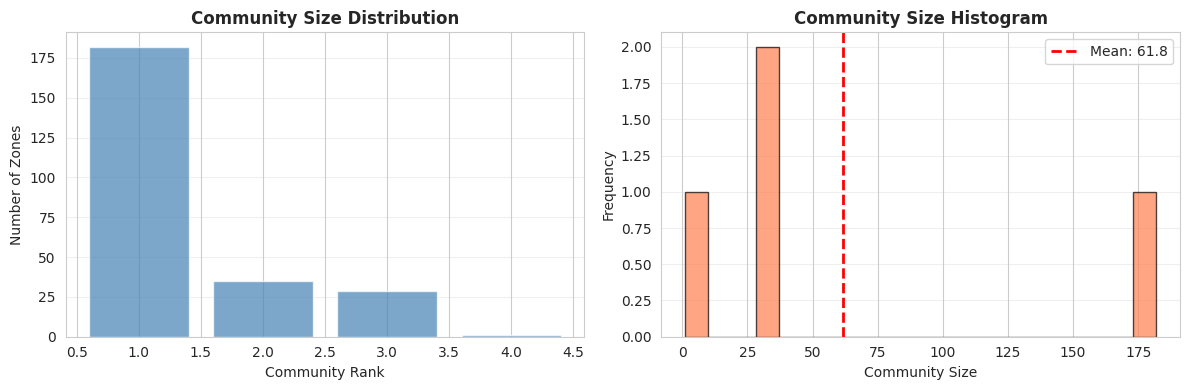


📊 Community Statistics:
   Largest: 182 zones
   Smallest: 1 zones
   Average: 61.8 zones


In [7]:
comm_sizes = [len(c) for c in communities]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Community size distribution
ax1.bar(range(1, len(comm_sizes)+1), sorted(comm_sizes, reverse=True), color='steelblue', alpha=0.7)
ax1.set_xlabel('Community Rank')
ax1.set_ylabel('Number of Zones')
ax1.set_title('Community Size Distribution', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Histogram
ax2.hist(comm_sizes, bins=20, color='coral', alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(comm_sizes), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(comm_sizes):.1f}')
ax2.set_xlabel('Community Size')
ax2.set_ylabel('Frequency')
ax2.set_title('Community Size Histogram', fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Community Statistics:")
print(f"   Largest: {max(comm_sizes)} zones")
print(f"   Smallest: {min(comm_sizes)} zones")
print(f"   Average: {np.mean(comm_sizes):.1f} zones")

## 6. Centrality Metrics Comparison

Compare different centrality measures to understand zone importance from multiple perspectives.

In [8]:
# Calculate multiple centrality metrics
degree_cent = nx.degree_centrality(G)
in_degree = dict(G.in_degree(weight='weight'))
out_degree = dict(G.out_degree(weight='weight'))

# Top hub zone
hub = top_nodes[0][0]

print(f"\n🎯 Hub Zone {hub} Metrics:")
print(f"   PageRank: {pagerank[hub]:.5f}")
print(f"   Degree Centrality: {degree_cent[hub]:.5f}")
print(f"   In-degree (arrivals): {in_degree[hub]:,}")
print(f"   Out-degree (departures): {out_degree[hub]:,}")


🎯 Hub Zone 236 Metrics:
   PageRank: 0.02265
   Degree Centrality: 0.78049
   In-degree (arrivals): 799,909
   Out-degree (departures): 763,005


## 7. Hub Flow Visualization

Analyze the top hub's connectivity pattern showing major inbound and outbound connections.

In [9]:
hub = top_nodes[0][0]
hub_edges = edges_df.filter((pl.col("source") == hub) | (pl.col("target") == hub))

# Top connections
top_in = hub_edges.filter(pl.col("target") == hub).sort("weight", descending=True).head(10)
top_out = hub_edges.filter(pl.col("source") == hub).sort("weight", descending=True).head(10)

print(f"\n🔵 Top 10 Inbound to Zone {hub}:")
for row in top_in.iter_rows(named=True):
    print(f"   Zone {row['source']:>3} → {hub}: {row['weight']:>6,} trips")

print(f"\n🔴 Top 10 Outbound from Zone {hub}:")
for row in top_out.iter_rows(named=True):
    print(f"   {hub} → Zone {row['target']:>3}: {row['weight']:>6,} trips")


🔵 Top 10 Inbound to Zone 236:
   Zone 237 → 236: 126,169 trips
   Zone 236 → 236: 82,683 trips
   Zone 161 → 236: 49,281 trips
   Zone 141 → 236: 41,055 trips
   Zone 263 → 236: 34,333 trips
   Zone 239 → 236: 33,553 trips
   Zone 142 → 236: 32,860 trips
   Zone 140 → 236: 32,613 trips
   Zone 262 → 236: 31,632 trips
   Zone 162 → 236: 30,113 trips

🔴 Top 10 Outbound from Zone 236:
   236 → Zone 237: 108,107 trips
   236 → Zone 236: 82,683 trips
   236 → Zone 161: 40,976 trips
   236 → Zone 141: 38,611 trips
   236 → Zone 239: 36,013 trips
   236 → Zone 238: 32,650 trips
   236 → Zone 142: 31,531 trips
   236 → Zone 162: 30,404 trips
   236 → Zone 262: 30,215 trips
   236 → Zone 263: 29,917 trips


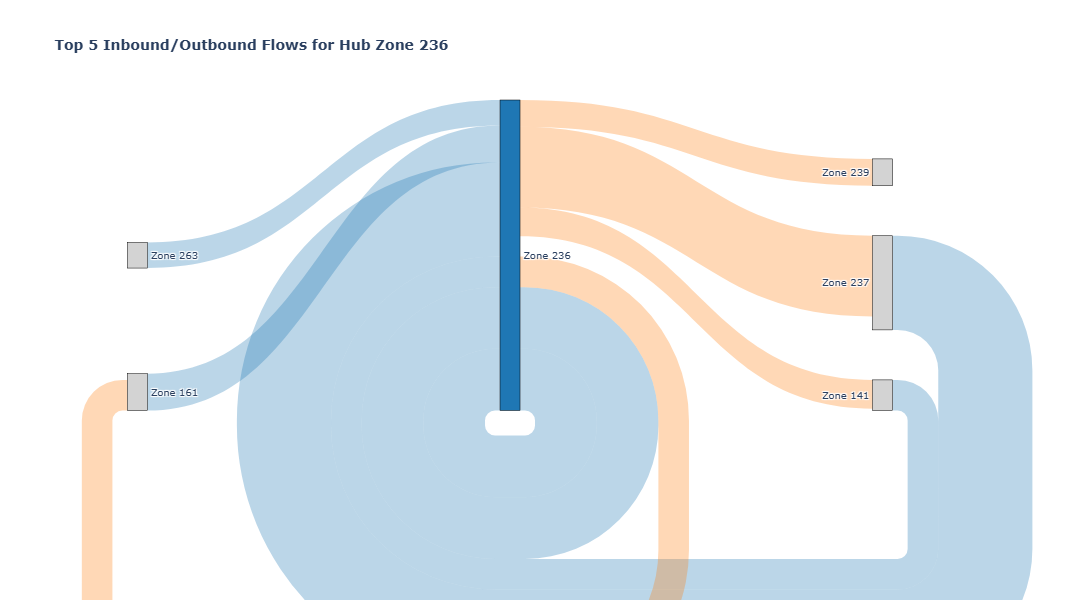

In [10]:
# Create flow chart for top connections
flow_data = pl.concat([
    top_in.head(5).select(['source', 'target', 'weight']),
    top_out.head(5).select(['source', 'target', 'weight'])
])

all_nodes = list(set(flow_data['source'].to_list() + flow_data['target'].to_list()))
node_map = {node: idx for idx, node in enumerate(all_nodes)}

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=[f"Zone {x}" for x in all_nodes],
        color=["#1f77b4" if x == hub else "#d3d3d3" for x in all_nodes]
    ),
    link=dict(
        source=[node_map[s] for s in flow_data['source']],
        target=[node_map[t] for t in flow_data['target']],
        value=flow_data['weight'].to_list(),
        color=["rgba(31, 119, 180, 0.3)" if t == hub else "rgba(255, 127, 14, 0.3)" 
               for t in flow_data['target']]
    )
)])

fig.update_layout(
    title=f"<b>Top 5 Inbound/Outbound Flows for Hub Zone {hub}</b>",
    font_size=10,
    height=600
)
fig.show()

## Key findings & recommendations

### Key Findings
*   **Network Scale**: 247 nodes (zones) connected by 11,158 edges with 18.36% density and average degree of 90.3.
*   **Hub Zones Identified**: Zone 236 leads in PageRank (0.0227) with 78% degree centrality—a critical network hub.
*   **Community Structure**: 4 distinct communities detected, with the largest containing 182 zones.
*   **Key Corridor**: Zone 237→236 is the busiest route with 126,169 trips.

### Business Recommendations
1.  **Hub Zone Priority**: Ensure high vehicle availability in Zone 236 and 237 as they are critical network hubs.
2.  **Community-Based Dispatch**: Use community structure to optimize dispatch—drivers within a community can serve that cluster efficiently.
3.  **Cross-Community Service**: Identify and strengthen connections between community clusters to improve network-wide coverage.